Algorithm after http://arxiv.org/pdf/1008.3477v2.pdf chapter 7.3.1

In [1]:
import numpy as np
from numpy import transpose as tr, conjugate as co
from scipy.linalg import expm, svd
import math
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 16, 9

### Some useful functions

In [2]:
def dot(A,B):
    """ Does the dot product like np.dot, but preserves the shapes also for singleton dimenstions """
    s1 = A.shape
    s2 = B.shape
    return np.dot(A,B).reshape((s1[0],s2[1]))

def truncated_svd(thetas,chi):
    """ Does an svd on two-site matrix thetas, and truncates to chi or the last nonzero singular value """
    U, S, Vh = svd(thetas,full_matrices = False)
    # trunkieren
    ind = np.where(np.isclose(np.cumsum(S[::-1])[::-1],0))[0]
    if len(ind)>0:
        chi_tr = min(chi,max(1,ind[0]))
    else:
        chi_tr = chi
    S=S[:chi_tr]
    w=1.-np.sum(S**2)
    S/=math.sqrt(1-w)
    U=U[:,:chi_tr]
    Vh=Vh[:chi_tr,:]
    return U, S, Vh

def left_canonize(thetas,s,chi, return_S = False):
    """ Splits up a two-site matrix thetas into two one-site matrices such that the left one is canonized """
    da, dg = thetas.shape[2], thetas.shape[3]
    thetas = thetas.transpose((2,0,3,1)).reshape((da*s,dg*s)) # combine indizes
    U, S, Vh = truncated_svd(thetas,chi)

    db     = len(S)
    U      = U.reshape((da,s,db)).transpose((1,0,2))
    Vh     = Vh.reshape((db,dg,s)).transpose((2,0,1))    
    for s2 in range(s):
        Vh[s2] = dot(np.diag(S),Vh[s2])
    if return_S:
        return U, Vh, S
    else:
        return U, Vh

def right_canonize(thetas,s,chi, return_S = False):
    """ Splits up a two-site matrix thetas into two one-site matrices such that the right one is canonized """
    da, dg = thetas.shape[2], thetas.shape[3]
    thetas = thetas.transpose((2,0,3,1)).reshape((da*s,dg*s)) # combine indizes
    U, S, Vh = truncated_svd(thetas,chi)

    db     = len(S)
    U      = U.reshape((da,s,db)).transpose((1,0,2))
    Vh     = Vh.reshape((db,dg,s)).transpose((2,0,1))    
    for s1 in range(s):
        U[s1] = dot(U[s1],np.diag(S))
    if return_S:
        return U, Vh, S
    else:
        return U, Vh


def apply_two_site_H(theta,H,s):
    """ Applies a two-site operator on the two-site matrix theta """
    thetas = np.zeros_like(theta)
    for s1p in range(s):
        for s2p in range(s):
            for s1 in range(s):
                for s2 in range(s):
                    thetas[s1p,s2p] += H[s1p*s+s2p,s1*s+s2] * theta[s1,s2]

    return thetas

def combine_two_matrices(M1,M2,s):
    """ Combines the two neighbouring one-site matrices M1 and M2 into a two-site matrix theta """
    da, db, dg=M1.shape[1], M1.shape[2], M2.shape[2]
    assert M1.shape[2] == M2.shape[1]

    theta = np.zeros((s,s,da,dg),dtype=complex)
    for s1 in range(s):
        for s2 in range(s):
            theta[s1,s2]=dot(M1[s1],M2[s2])

    return theta

### Definition of system and initializiation

In [3]:
J   = 1.
L   = 20     # Length of chain
s   = 2      # Local dimension of Hilbert space
dt  = 0.05   # The imaginary timestep (should be 0.01 or smaller for good accuracy)
chi = 60     # The maximum matrix dimension, from which on the matrices are truncated
nmax = 10000 # Maximum number of iterations
nskip = 10   # Check energy convergence after nskip steps

# Two-site Hamiltonian
H  = np.array([[J/4,0,0,0],
              [0,-J/4,J/2,0],
              [0,J/2,-J/4,0],
              [0,0,0,J/4]])

# Imaginary time evolution operator
exp_beta_H=expm(-H*dt);

# antiferromagnetic starting configuration
M = []
for i in range(L):
    ar = np.zeros((2,1,1),dtype=complex)
    ar[0,0,0] = i%2
    ar[1,0,0] = (i+1)%2
    M.append(ar)

even = np.array(range(0,L-1,2))
odd  = np.array(range(L+L%2-2,0,-2))

### Imaginary time evolution

In [4]:
enold = 0. # for checking energy convergence

for n in range(nmax):
    # ++++ Trotter scheme: first even bonds, than odd bonds
    # === apply exp_beta_H on all even bonds ===
    for j in even:
        # go from left to right
        theta = combine_two_matrices(M[j],M[j+1],s)
        thetas = apply_two_site_H(theta,exp_beta_H,s)        
        M[j], M[j+1]   = left_canonize(thetas,s,chi)

        # advance left canonization by a further step
        if j < L-2:
            theta = combine_two_matrices(M[j+1],M[j+2],s)            
            M[j+1], M[j+2]  = left_canonize(theta,s,chi)
    # === apply exp_beta_H on all even bonds ===

    # === renormalize the state on the last site ===
    da = M[L-1].shape[1]
    theta = M[L-1].reshape((s*da,1))
    U, _, _ = truncated_svd(theta,chi) # throw away norm
    M[L-1] = U.reshape((s,da,1))
    # === renormalize the state on the last site ===

    if L%2 == 0:
        # the right-most matrix has to be right canonized in this case
        theta = combine_two_matrices(M[L-2],M[L-1],s)
        M[L-2], M[L-1]  = right_canonize(theta,s,chi)

    # === apply exp_beta_H on all odd bonds ===
    for j in odd:
        # go from right to left
        theta  = combine_two_matrices(M[j-1],M[j],s)
        thetas = apply_two_site_H(theta,exp_beta_H,s)
        M[j-1], M[j]   = right_canonize(thetas,s,chi)

        # advance right canonization by a further step
        if j>1:
            theta = combine_two_matrices(M[j-2],M[j-1],s)
            M[j-2], M[j-1]  = right_canonize(theta,s,chi)
    # === apply exp_beta_H on all odd bonds ===

    # === renormalize the state on the first site ===
    db = M[0].shape[2]
    theta = M[0].reshape((1,s*db))
    _, _, Vh = truncated_svd(theta,chi) # throw away norm
    M[0] = Vh.reshape((s,1,db))
    # === renormalize the state on the first site ===

    # ++++ Calculate energy and check convergence ++++
    if n%nskip == 0:
        # Measure Energy via sum of two-site Operators H
        en = 0.
        for j in range(L-1):            
            theta  = combine_two_matrices(M[j],M[j+1],s)
            thetas = apply_two_site_H(theta,H,s)            
            for s1 in range(s):
                for s2 in range(s):
                    en += np.trace(dot(thetas[s1,s2],co(tr(theta[s1,s2])))).real
            M[j], M[j+1]   = left_canonize(theta,s,chi) # Proceed with left canonization

        # make right canonized MPS for next tDMRG step
        for j in range(L-1,0,-1):
            theta = combine_two_matrices(M[j-1],M[j],s)
            M[j-1], M[j]  = right_canonize(theta,s,chi)

        print(n,'dE = ',abs(en-enold))
        if abs(en-enold) < 1e-8:
            print("Converged after "+str(n)+" steps!")
            print("Ground-state energy: " + str(en))
            break
        enold = en
    # === check convergence ===

if n == nmax:
    print("Maximum iterations reached! Convergence criterium not satisfied!")

0 dE =  5.2022859299
10 dE =  2.41237932615
20 dE =  0.616048162871
30 dE =  0.19945192398
40 dE =  0.0856110936378
50 dE =  0.0446638884127
60 dE =  0.0266683370958
70 dE =  0.0176509913134
80 dE =  0.0127047223848
90 dE =  0.00977408061919
100 dE =  0.00789488605981
110 dE =  0.00658572945765
120 dE =  0.00559930606822
130 dE =  0.00480731763688
140 dE =  0.00414298945949
150 dE =  0.0035712463933
160 dE =  0.00307305023898
170 dE =  0.00263722905494
180 dE =  0.00225631290084
190 dE =  0.00192449985237
200 dE =  0.00163673118822
210 dE =  0.00138832203542
220 dE =  0.0011748521653
230 dE =  0.000992164333084
240 dE =  0.000836395474847
250 dE =  0.000704007231025
260 dE =  0.000591803752473
270 dE =  0.000496934572579
280 dE =  0.000416884722746
290 dE =  0.000349455574773
300 dE =  0.000292739848431
310 dE =  0.000245093656
320 dE =  0.000205107728403
330 dE =  0.000171579325436
340 dE =  0.000143485782885
350 dE =  0.000119960236445
360 dE =  0.000100269773123
370 dE =  8.37960556

### Measure and plot the Entanglement Entropy between all sites

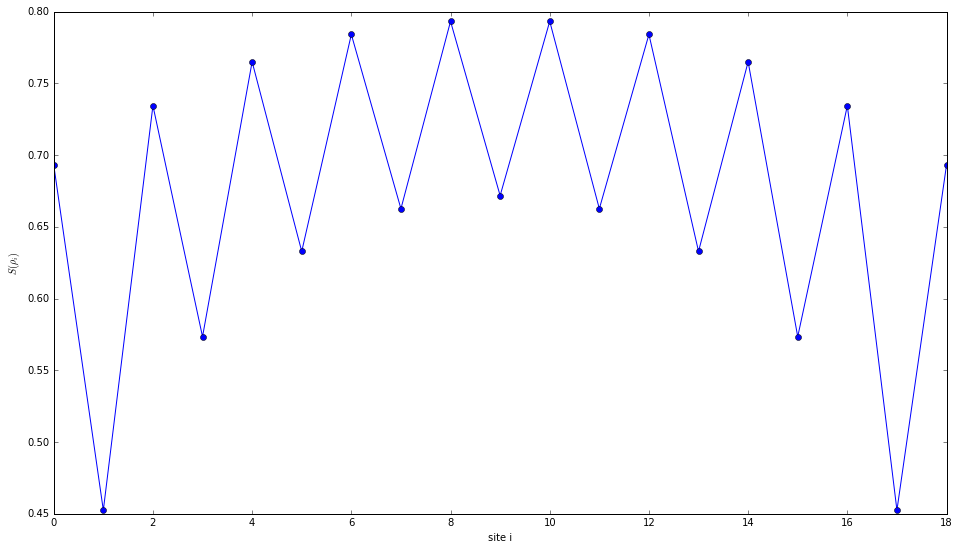

In [5]:
ent = np.zeros((L-1))
## warning measurment assumes right canonized MPS
for j in range(L-1):
    theta  = combine_two_matrices(M[j],M[j+1],s)
    M[j], M[j+1], S = left_canonize(theta,s,chi, return_S = True)
    ent[j] = -np.sum(S**2*np.log(S**2))


plt.figure()
plt.plot(ent,'-o')
plt.xlabel('site i')
plt.ylabel(r'$S(\rho_i)$')
plt.show()